# Gibbs Sampling Based Posterior Approximation
In the below python notebook, we try to model the boston house prediction data through multi-level regression dataset. We propose a probabistic model for the same and performs Gibbs sampling based approximation of posterior due to intractable nature of posterior.

In [1]:
#Author: Shrey Bhatt (20111060)

from sklearn.datasets import load_boston
data_obj = load_boston()
#print(data_obj)
#print(data_obj['data'][0:3])
feat = data_obj['data'][:,[0,1,3,5,6,8,9]]
targ = data_obj['target']
targ = targ.reshape((len(targ),1))


## Feature Scaling
We use the features crime rate, propostion of residential land zone, charles river presence, average rooms per dwelling, proportion of owner-occupied units built prior 1940, accessibility of radial highways and property tax rate to predict the housing value. As each feature consist of different domain, we perform feature scaling prior to use of data. Also, we append a constant 1 to end of features for later introducing a bias-like term in our model.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

f_scale = StandardScaler()
t_scale = StandardScaler()

X = f_scale.fit_transform(feat)
y = t_scale.fit_transform(targ)
X = np.concatenate((X,np.ones((len(feat),1))),axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#print(X,y)

## Probabilistic hierarchical regression model
We propose the below probabilistic model for analyzing the relationship between features and target variable. The likelihood for the target variable y is given as:

$p(y_n | x_n, w, \beta) = \mathcal{N}(w^T x_n, \beta^{-1})$

The prior for  various parameters are given as:

$p(w | s_1, s_2, s_3 ... s_D) = \mathcal{N}(w | 0, diag(s_1^{-1}, s_2^{-1} ... s_D^{-1}))$

$p(\beta) = Gamma(\beta | \alpha, \lambda)$

$p(s_i) = Gamma(s_i | a_i, b_i)$

###Intractable Posterior

However, the posterior of the above model is intractable as it is given by:

$p(w, \beta, s_1, s_2 ... s_D | y, X) = \frac{p(y, w, \beta, s_1, s_2 ... s_D | X)}{p(y|X)}\\ = \frac{p(y | X, w, \beta) p(w |, s_1, s_2 ... s_D) p(\beta) p(s_1, s_2 ... s_D)}{\int p(y | X, w, \beta) p(w |, s_1, s_2 ... s_D) p(\beta) p(s_1, s_2 ... s_D) d(w, \beta, s_1 ,s_2 ... s_D) }$

The denominator is an integral of product of Gaussian and multiple Gamma distributions, which make it intractable to compute.

## Sampling to the rescue ...
Although the above posterior is intractable, there is local conjugacy among the parameters and this allows us to apply an approximate sampling method to estimate the posterior i.e. Gibbs Sampling. Gibbs sampling is a type of MCMC sampling and is very popular in such hierarchical models where local conjugacy is prevalent.

To perform Gibbs Sampling, we need to find condititonal posterior for every parameter and use them to generate samples. The distribution for conditional posterior for various parameters are as given below:


### Conditional posterior for w

$p(w | y, X, \beta, s_1, s_2 ... s_D) = \frac{p(w, y | X, \beta, s_1, s_2 ... s_D)}{p(y | X, \beta, s_1, s_2 ... s_D)}
= \frac{p(y | w, X, \beta) p(w |  s_1, s_2 ... s_D)}{p(y | X, \beta, s_1, s_2 ... s_D)}$

$= \frac{\mathcal{N}(y | Xw, \beta^{-1} I_N) \mathcal{N}(w | 0, diag(s_1^{-1}, s_2^{-1} ... s_D^{-1}))}{\int \mathcal{N}(y | Xw, \beta^{-1} I_N) \mathcal{N}(w | 0, diag(s_1^{-1}, s_2^{-1} ... s_D^{-1})) dw}$

$= \mathcal{N}(w | ( X^T X + \beta^{-1} diag(s_1, s_2 ... s_D))^{-1} X^T y, ( \beta X^T X + diag(s_1, s_2 ... s_D))^{-1})$

$ = \mathcal{N}(w | \mu_w, \Sigma_w)$

### Conditional posterior for $\beta$

$p(\beta | y, X, w, s_1, s_2 ... s_D) = \frac{p(\beta, y | w, X, s_1, s_2 ... s_D)}{p(y | X, w, s_1, s_2 ... s_D)}
= \frac{p(y | w, X, \beta) p(\beta)}{p(y | X, w, s_1, s_2 ... s_D)}$

$ = \frac{\frac{1}{\sqrt{(2 \pi)^N |\beta^{-1} I_N|}} exp(\frac{-\beta}{2} (y - Xw)^T (y - Xw)) \times (\beta)^{(\alpha-1)} exp[-\beta \lambda]}{p(y | X, w, s_1, s_2 ... s_D)}$

$ = \frac{(2 \pi)^{\frac{-N}{2}} (\beta)^{(\alpha + N/2 - 1)} exp( -\beta[(y - Xw)^T (y - Xw)/2 + \lambda])}{p(y | X, w, s_1, s_2 ... s_D)}$

$ = Gamma(\beta | \alpha + \frac{N}{2}, \lambda + \frac{1}{2}(y -  Xw)^T(y - Xw))$


### Condition posterior for $s_i$

$p(s_i | y, X, w, \beta, s_{-i}) = \frac{p(s_i, w | \beta, s_{-i})}{p(w | \beta, s_{-i})}
= \frac{p(w | s_1 ... s_D) p(s_i)}{p(w | \beta, s_{-i})}$

$ = \frac{\frac{1}{\sqrt{(2 \pi)^D |diag(s_1^{-1} , s_2^{-1} ... s_D^{-1})|}} exp(\frac{-1}{2} \sum_{d=1}^D w_d^2 s_d) (s_i)^{(a_i - 1)} exp[-b_i s_i]}{p(w | \beta, s_{-i})}$

$ = \frac{ (s_i)^{(a_i - 1 + 1/2)} exp[- s_i(\frac{w_i^2}{2} + b_i)]}{\int (s_i)^{(a_i - 1 + 1/2)} exp[- s_i(\frac{w_i^2}{2} + b_i)] d(s_i)}$

$ = Gamma(s_i | a_i + \frac{1}{2}, b_i + \frac{w_i^2}{2})$


Using these conditional posteriors, we generate $S$ samples of each parameter, which represent the samples of posterior.

In [3]:
def gen_samples(num_samples,a_arr,b_arr,alpha_v,lambda_v,X,y):
  dims = len(X[0])
  X_len = len(X)
  w = np.zeros((dims))
  si = np.zeros((dims))
  beta = 0

  for d in range(dims):
    si[d] = np.random.gamma(a_arr[d],b_arr[d])
  beta = np.random.gamma(alpha_v,lambda_v)

  beta_samples = []
  si_samples = []
  w_samples = []

  for i in range(num_samples):
    Xt_X = np.matmul(np.transpose(X),X)
    diagmat = np.zeros((dims,dims))
    for j in range(dims):
      diagmat[j][j] = si[j]
    covw = np.linalg.inv(beta*Xt_X + diagmat)
    Xt_y = np.matmul(np.transpose(X),y)
    meanw = (np.matmul(covw,Xt_y)*beta).reshape((dims))
    #print(meanw)
    #print(covw)
    w = np.random.multivariate_normal(mean=meanw,cov = covw)
    #print(w)
    preds = np.matmul(X,w)
    preds= preds.reshape((len(preds),1))
    #print(preds)
    diff_vec = y - preds
    #if i==0:
      #print(diff_vec)
    sq_loss = np.sum(diff_vec**2)
    #print(sq_loss)
    #print(sq_loss)
    #print(diff_vec)
    beta = np.random.gamma(shape = alpha_v + X_len/2, scale = lambda_v + sq_loss/2)
    #print(beta)
    si = np.zeros((dims))
    for j in range(dims):
      si[j] = np.random.gamma(shape=a_arr[j] + 0.5,scale = b_arr[j] + (w[j]**2)/2)
    #print(si)
    beta_samples.append(beta)
    si_samples.append(si)
    w_samples.append(w)

  return w_samples, beta_samples, si_samples


In [4]:
from random import randint

numS = 1000
dims = len(X_train[0])
a_arr = np.zeros((dims))
b_arr = np.zeros((dims))
alpha_v = 0
lambda_v = 0

for i in range(dims):
  a_arr[i] = randint(1,5)
  b_arr[i] = randint(1,5)

alpha_v = randint(1,5)
lambda_v = randint(1,5)

#print(a_arr)
#print(b_arr)
#print(alpha_v)
#print(lambda_v)

w, beta, si = gen_samples(numS,a_arr,b_arr,alpha_v,lambda_v,X_train,y_train)
#print(w)


## Making prediction using the samples

Now, that we have generated the samples for posterior, we need to use them and make predictions. The expression for posterior predictive distribution is given by:

$p(y_* | x_*, y, X) = \int p(y_* | x_*, w, \beta) p(w, \beta, s_1, s_2 ... s_D | y, X) d(w, \beta, s_1, s_2 ... s_D)$

Now, since the samples have already been generated w.r.t the posterior probabilitiy, we simply need to substitute them into the first term of the PPD in order to compute expected prediction and uncertainty/variance in prediction

$p(y_* | x_*, y, X) = \frac{1}{S} \sum_{s=1}^S p(y_* | x_*, w^{(s)}, \beta^{(s)})$

Although one might wonder that the samples generated for $s_i$ are not used in PPD, but they have been indirectly useful for generating sample for $w$ and $\beta$ and so, in that way they have act as prior parameters.

The expected prediction for any input is given as:

$E[y_*] = E[w^T x_* + \epsilon] = \frac{1}{S} \sum_{s=1}^S E[\mathcal{N(y_* | (w^{(s)})^T x_*, \beta^{-1})}] + 0 = \frac{1}{S} \sum_{s=1}^S (w^{(s)})^T x_*$

The variance in prediction for any input is given as:

$var[y_*] = var[w^T x_* + \epsilon] = var[w^T x_*] + var[\epsilon]$

$ = \frac{1}{S} \sum_{s=1}^S ((w^{(s)})^T x_*)^2 - (\frac{1}{S} \sum_{s=1}^S (w^{(s)})^T x_*)^2 + \frac{1}{S} \sum_{s=1}^S (\beta^{(s)})^{-1}$

In fact, taking more samples allow you to estimate the extent of uncertainty/variance in prediction of a given input.

In [5]:
def predict_y(x,w_samp,beta_samp):
  #print(beta_samp)
  numsamp = len(w_samp)
  pred = np.zeros((numsamp))
  for i in range(numsamp):
    pred[i] = np.dot(w_samp[i],x)
  #print(pred)
  mean_pred = np.mean(pred)
  #print(mean_pred)
  predsq = pred**2
  betavar = 0
  for betas in beta_samp:
    betavar += 1/betas
  var_pred = np.mean(predsq) - (mean_pred**2) + betavar/numsamp
  #print(mean_pred, var_pred)
  return mean_pred,var_pred

In [6]:
def eval(X,y,w,beta):
  mean_sq_loss = 0
  for i in range(len(X)):
    meanp, varp = predict_y(X[i],w,beta)
    mean_sq_loss+=(meanp - y[i][0])**2
  mean_sq_loss/=len(X)
  return mean_sq_loss

In [7]:
meansqloss = eval(X_test,y_test,w,beta)
print('Mean squared loss: ', meansqloss)

Mean squared loss:  0.42829705315265876


## Mean squared loss over the original-data
After measuring the mean squared loss over transformed/scaled data, we also measure the mean squared loss over original-data to know the extent of deviation of target and predicted values

In [8]:
mean_sq_loss_orig = 0
pred_vals = np.zeros((len(X_test)))
for i in range(len(X_test)):
  meanp, varp = predict_y(X_test[i],w,beta)
  pred_vals[i] = meanp
pred_vals = pred_vals.reshape((len(pred_vals),1))
pred_orig = t_scale.inverse_transform(pred_vals)
y_orig = t_scale.inverse_transform(y_test)
mean_sq_loss_orig = np.mean((pred_orig - y_orig)**2)
print('Mean squared loss over untransformed data: ', mean_sq_loss_orig)

Mean squared loss over untransformed data:  36.156647130141096


## Plots over different attributes
The plot of target and predition over attributes like tax and crime rate is as shown below:

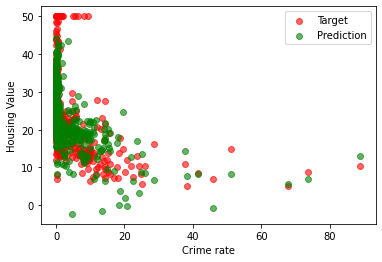

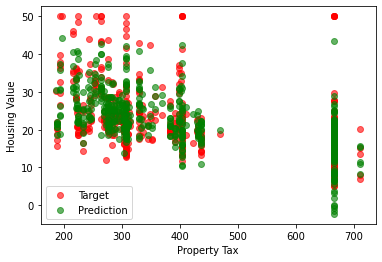

In [9]:
import matplotlib.pyplot as plt

pred_y = np.zeros((len(X)))
for i in range(len(X)):
  pred_y[i], varp = predict_y(X[i],w,beta)
pred_y = pred_y.reshape((len(pred_y),1))
pred_y = t_scale.inverse_transform(pred_y)

plt.xlabel('Crime rate')
plt.ylabel('Housing Value')
plt.scatter(feat[:,0],targ,c='red',alpha=0.6,label='Target')
plt.scatter(feat[:,0],pred_y,c='green',alpha=0.6,label='Prediction')
plt.legend()
plt.show()

plt.xlabel('Property Tax')
plt.ylabel('Housing Value')
plt.scatter(feat[:,6],targ,c='red',alpha=0.6,label='Target')
plt.scatter(feat[:,6],pred_y,c='green',alpha=0.6,label='Prediction')
plt.legend()
plt.show()
